In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(2)
from sklearn.model_selection import train_test_split

SEED = 123
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("rare_event_data.csv") 

In [3]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    df = df.drop(df[df[labelcol] == 1].index)
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    df.loc[df[labelcol] > 0, labelcol] = 1
    return df

In [4]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [5]:
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])    
    return X

In [6]:
df = curve_shift(df, shift_by = -2)

In [7]:
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [8]:
input_X = df.loc[:, df.columns != 'y'].values
input_y = df['y'].values

n_features = input_X.shape[1]

In [9]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [10]:
lookback = 5
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [12]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [13]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [14]:
scaler = StandardScaler().fit(flatten(X_train_y0))

In [15]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [16]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

In [17]:
timesteps =  X_train_y0_scaled.shape[1]
n_features =  X_train_y0_scaled.shape[2]

epochs = 200
batch = 64
lr = 0.0001

In [18]:
lstm_autoencoder = Sequential()

lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))

In [19]:
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

In [20]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

In [21]:
cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

In [22]:
tb = TensorBoard(log_dir='logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [23]:
lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=1).history

Train on 11536 samples, validate on 2880 samples
Epoch 1/200
11536/11536 [==============================] - 11s 995us/sample - loss: 0.9910 - val_loss: 1.0024
Epoch 2/200
11536/11536 [==============================] - 5s 455us/sample - loss: 0.9003 - val_loss: 0.8493
Epoch 3/200
11536/11536 [==============================] - 6s 480us/sample - loss: 0.7686 - val_loss: 0.7166
Epoch 4/200
11536/11536 [==============================] - 5s 399us/sample - loss: 0.6651 - val_loss: 0.6205
Epoch 5/200
11536/11536 [==============================] - 5s 399us/sample - loss: 0.5894 - val_loss: 0.5543
Epoch 6/200
11536/11536 [==============================] - 5s 438us/sample - loss: 0.5378 - val_loss: 0.5108
Epoch 7/200
11536/11536 [==============================] - 5s 446us/sample - loss: 0.5009 - val_loss: 0.4793
Epoch 8/200
11536/11536 [==============================] - 5s 450us/sample - loss: 0.4725 - val_loss: 0.4537
Epoch 9/200
11536/11536 [==============================] - 5s 404us/sample - l

Epoch 75/200
11536/11536 [==============================] - 4s 376us/sample - loss: 0.1967 - val_loss: 0.2078
Epoch 76/200
11536/11536 [==============================] - 4s 372us/sample - loss: 0.1957 - val_loss: 0.2030
Epoch 77/200
11536/11536 [==============================] - 4s 370us/sample - loss: 0.1951 - val_loss: 0.2024
Epoch 78/200
11536/11536 [==============================] - 4s 372us/sample - loss: 0.1943 - val_loss: 0.2003
Epoch 79/200
11536/11536 [==============================] - 4s 369us/sample - loss: 0.1935 - val_loss: 0.2059
Epoch 80/200
11536/11536 [==============================] - 4s 390us/sample - loss: 0.1928 - val_loss: 0.1993
Epoch 81/200
11536/11536 [==============================] - 4s 387us/sample - loss: 0.1918 - val_loss: 0.2044
Epoch 82/200
11536/11536 [==============================] - 4s 373us/sample - loss: 0.1914 - val_loss: 0.2005s: 0.19 - ETA: 0s - loss: 0.1
Epoch 83/200
11536/11536 [==============================] - 4s 373us/sample - loss: 0.1905 

Epoch 149/200
11536/11536 [==============================] - 4s 385us/sample - loss: 0.1595 - val_loss: 0.1730
Epoch 150/200
11536/11536 [==============================] - 6s 480us/sample - loss: 0.1590 - val_loss: 0.1730
Epoch 151/200
11536/11536 [==============================] - 5s 391us/sample - loss: 0.1589 - val_loss: 0.1724
Epoch 152/200
11536/11536 [==============================] - 4s 381us/sample - loss: 0.1585 - val_loss: 0.1702
Epoch 153/200
11536/11536 [==============================] - 5s 403us/sample - loss: 0.1588 - val_loss: 0.1721
Epoch 154/200
11536/11536 [==============================] - 4s 381us/sample - loss: 0.1582 - val_loss: 0.1706
Epoch 155/200
11536/11536 [==============================] - 5s 391us/sample - loss: 0.1577 - val_loss: 0.1768
Epoch 156/200
11536/11536 [==============================] - 5s 396us/sample - loss: 0.1573 - val_loss: 0.1721
Epoch 157/200
11536/11536 [==============================] - 4s 385us/sample - loss: 0.1571 - val_loss: 0.1710
E

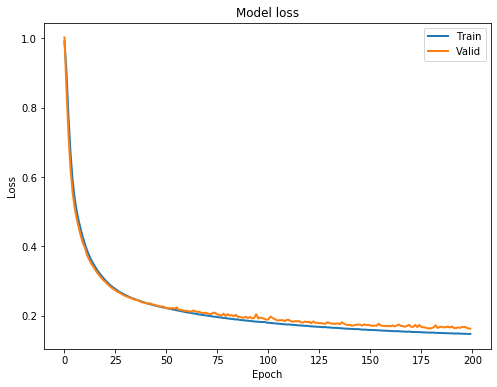

In [24]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

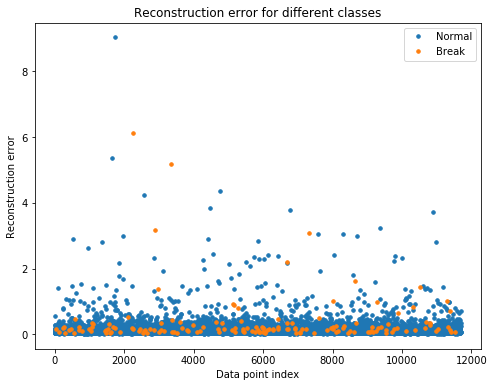

In [25]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

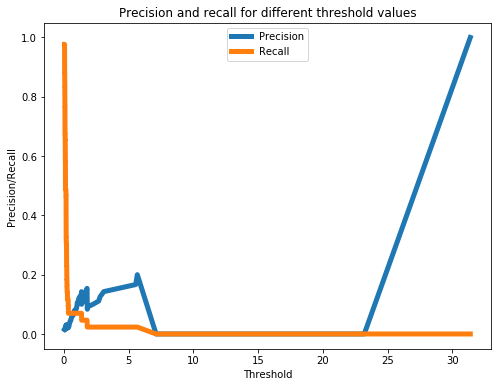

In [26]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

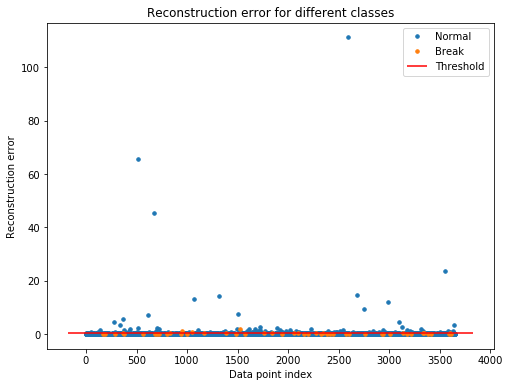

In [27]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

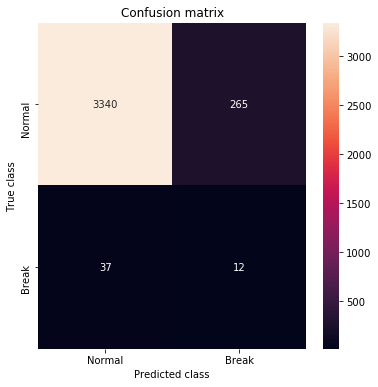

In [28]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

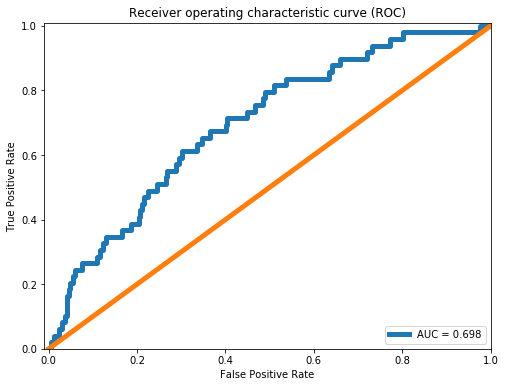

In [29]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()